In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import pickle

In [2]:
### IN THIS SECTION CHECK OUT ALL RELEVANT VERSIONS OF Python COMPONENTS USED

In [3]:
import pandas
print(pandas.__version__)

2.0.3


In [4]:
import numpy
print(numpy.__version__)

1.23.5


In [5]:
!python --version

Python 3.8.5


In [6]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /Users/xiomara/opt/anaconda3/lib/python3.8/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: category-encoders, evidently, pyod


In [7]:
!which python

/Users/xiomara/opt/anaconda3/bin/python


In [8]:
!which conda

/Users/xiomara/opt/anaconda3/bin/conda


In [9]:
!conda --version

conda 4.12.0


In [10]:
# !pip3 freeze > requirements.txt

In [11]:
!pip3 freeze | grep '==' > requirements.txt

In [12]:
# import data: CHLA_DATA.csv
df = pd.read_csv('CHLA_DATA.csv')

In [13]:
df.head()

,MRN,APPT_STATUS,APPT_DATE,BOOK_DATE,ZIPCODE,CLINIC,SCHEDULE_ID,APPT_ID,LEAD_TIME,IS_REPEAT,...,TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT,TOTAL_NUMBER_OF_NOSHOW,DAY_OF_WEEK,WEEK_OF_MONTH,NUM_OF_MONTH,HOUR_OF_DAY,IS_NOSHOW,AGE,ETHNICITY_STANDARDIZE,RACE_STANDARDIZE
0,4469690,CONFIRMED,12/5/23 10:30,6/5/23 12:02,93550,VALENCIA CARE CENTER,22570578,77117078,182,Y,...,2,0,1,1,12,10,N,17,Others,Other
1,4497581,CONFIRMED,11/27/23 11:00,5/30/23 9:25,91335,VALENCIA CARE CENTER,22539155,77017428,181,Y,...,1,0,0,4,11,11,N,11,Hispanic,SouthAmerican
2,1827827,CONFIRMED,11/17/23 13:30,5/19/23 14:13,91118,ARCADIA CARE CENTER,22502756,76884745,181,Y,...,4,0,4,3,11,13,N,14,Non-Hispanic,Asian
3,4398915,CONFIRMED,11/15/23 10:00,5/26/23 11:22,92019,ARCADIA CARE CENTER,22534280,76987765,172,Y,...,4,0,2,3,11,10,N,19,Non-Hispanic,European
4,4372854,CONFIRMED,11/14/23 15:30,5/30/23 15:48,91350,VALENCIA CARE CENTER,22547163,77032036,167,Y,...,1,0,1,2,11,15,N,17,Others,Other


In [14]:
df.dtypes

MRN                                          int64
APPT_STATUS                                 object
APPT_DATE                                   object
BOOK_DATE                                   object
ZIPCODE                                     object
CLINIC                                      object
SCHEDULE_ID                                  int64
APPT_ID                                      int64
LEAD_TIME                                    int64
IS_REPEAT                                   object
APPT_TYPE_STANDARDIZE                       object
APPT_NUM                                     int64
TOTAL_NUMBER_OF_CANCELLATIONS                int64
TOTAL_NUMBER_OF_RESCHEDULED                  int64
TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT     int64
TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT          int64
TOTAL_NUMBER_OF_NOSHOW                       int64
DAY_OF_WEEK                                  int64
WEEK_OF_MONTH                                int64
NUM_OF_MONTH                   

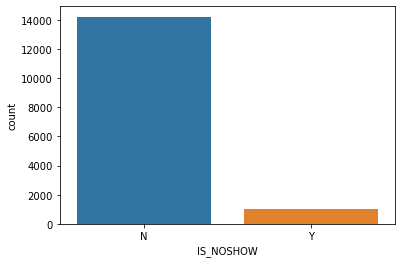

IS_NOSHOW
N    14216
Y     1033
Name: count, dtype: int64
IS_NOSHOW
N    93.225785
Y     6.774215
Name: proportion, dtype: float64


In [15]:
# plot the distribution of the target variable: IS_NOSHOW
sns.countplot(df['IS_NOSHOW'])
plt.show()

# show the count and percentage of each class
print(df['IS_NOSHOW'].value_counts())
print(df['IS_NOSHOW'].value_counts(normalize=True) * 100)

In [16]:
# show no. of unique values for each categorical column
df.select_dtypes(include='object').nunique()

APPT_STATUS                  6
APPT_DATE                 9134
BOOK_DATE                12114
ZIPCODE                    590
CLINIC                       6
IS_REPEAT                    2
APPT_TYPE_STANDARDIZE        3
IS_NOSHOW                    2
ETHNICITY_STANDARDIZE        3
RACE_STANDARDIZE             7
dtype: int64

In [17]:
# manually dropping columns based on EDA and domain knowledge

# drop APPT_STATUS column because it gives the answer to the target variable
df = df.drop(columns=['APPT_STATUS'])

# drop identifier columns (irrelevant): MRN, APPT_ID, SCHEDULE_ID
df = df.drop(columns=['MRN', 'APPT_ID', 'SCHEDULE_ID'])

# drop APPT_NUM because it has a high correlation with TOTAL_NUMBER_OF_RESCHEUDLED and TOTAL_NUMBER_OF_SUCCESSFUL_APPOINTMENT
df = df.drop(columns=['APPT_NUM'])


# not sure about these (include in encoding if using them)
# drop APPT_DATE and BOOK_DATE because they are redundant (DAY_OF_WEEK, WEEK_OF_MONTH, NUM_OF_MONTH, and LEAD_TIME are enough)
df = df.drop(columns=['APPT_DATE', 'BOOK_DATE'])

# drop ZIPCODE because it has too many unique values, and it does not provide any useful information
df = df.drop(columns=['ZIPCODE'])

In [18]:
# show no. of unique values for each categorical column
df
#cat_cols = df.select_dtypes(include=['object']).columns
#df.columns # the features apart of the model

,CLINIC,LEAD_TIME,IS_REPEAT,APPT_TYPE_STANDARDIZE,TOTAL_NUMBER_OF_CANCELLATIONS,TOTAL_NUMBER_OF_RESCHEDULED,TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT,TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT,TOTAL_NUMBER_OF_NOSHOW,DAY_OF_WEEK,WEEK_OF_MONTH,NUM_OF_MONTH,HOUR_OF_DAY,IS_NOSHOW,AGE,ETHNICITY_STANDARDIZE,RACE_STANDARDIZE
0,VALENCIA CARE CENTER,182,Y,Follow-up,0,0,0,2,0,1,1,12,10,N,17,Others,Other
1,VALENCIA CARE CENTER,181,Y,Follow-up,0,0,0,1,0,0,4,11,11,N,11,Hispanic,SouthAmerican
2,ARCADIA CARE CENTER,181,Y,Follow-up,0,2,0,4,0,4,3,11,13,N,14,Non-Hispanic,Asian
3,ARCADIA CARE CENTER,172,Y,Follow-up,0,3,0,4,0,2,3,11,10,N,19,Non-Hispanic,European
4,VALENCIA CARE CENTER,167,Y,Follow-up,1,0,0,1,0,1,2,11,15,N,17,Others,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15244,SOUTH BAY CARE CENTER,23,N,Follow-up,0,0,0,1,1,2,3,8,14,Y,22,Others,Other
15245,SOUTH BAY CARE CENTER,19,N,New,0,0,0,0,1,2,3,8,11,Y,5,Non-Hispanic,Other
15246,SOUTH BAY CARE CENTER,188,N,Follow-up,1,1,0,2,1,2,3,8,9,Y,9,Others,Other
15247,SOUTH BAY CARE CENTER,20,N,New,0,0,0,0,1,2,3,8,9,Y,5,Non-Hispanic,European


# Encoding

In [19]:
df['IS_NOSHOW'] = df['IS_NOSHOW'].map({'Y': 1, 'N': 0})
df['IS_REPEAT'] = df['IS_REPEAT'].map({'Y': 1, 'N': 0})

category_col =['CLINIC', 'APPT_TYPE_STANDARDIZE', 'ETHNICITY_STANDARDIZE', 'RACE_STANDARDIZE']  
lbl_data = df.copy()
df_input = df[category_col].copy()
enc = preprocessing.LabelEncoder()
encoder_dict = dict()

for cat in category_col:
    df_input[cat] = df_input[cat].str.lstrip()
    enc = enc.fit(list(df_input[cat]) + ['Unknown'])
    encoder_dict[cat] = [cat for cat in enc.classes_]
    lbl_data[cat] = enc.transform(df_input[cat])

encoder_dict['IS_NOSHOW'] = {'Y': 1, 'N': 0}
encoder_dict['IS_REPEAT'] = {'Y': 1, 'N': 0}

encoder_dict
#lbl_data
#df_input

{'CLINIC': ['ARCADIA CARE CENTER',
  'BAKERSFIELD CARE CLINIC',
  'ENCINO CARE CENTER',
  'SANTA MONICA CLINIC',
  'SOUTH BAY CARE CENTER',
  'Unknown',
  'VALENCIA CARE CENTER'],
 'APPT_TYPE_STANDARDIZE': ['Follow-up', 'New', 'Others', 'Unknown'],
 'ETHNICITY_STANDARDIZE': ['Hispanic', 'Non-Hispanic', 'Others', 'Unknown'],
 'RACE_STANDARDIZE': ['African',
  'Asian',
  'European',
  'MiddleEastern',
  'NorthAmerican',
  'Other',
  'SouthAmerican',
  'Unknown'],
 'IS_NOSHOW': {'Y': 1, 'N': 0},
 'IS_REPEAT': {'Y': 1, 'N': 0}}

# Save Encoder

In [20]:
encoder_pickle_out = open("encoder_V2.pkl", "wb")
pickle.dump(encoder_dict, encoder_pickle_out)
encoder_pickle_out.close()

# EDA

Text(0.5, 1.0, '<=50K Income vs >50K Income Count')

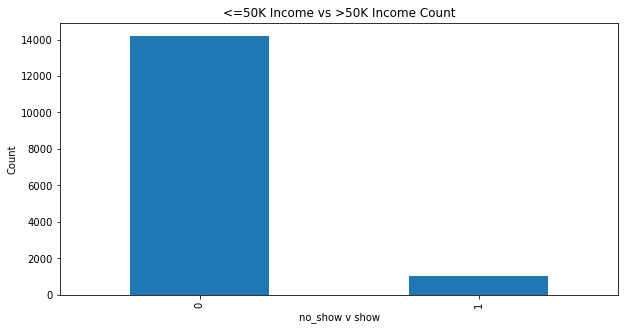

In [21]:
# 
plt.figure(figsize=(10,5))
ax = lbl_data.IS_NOSHOW.value_counts().plot(kind = 'bar')
plt.xlabel("no_show v show")
plt.ylabel("Count")
plt.title("<=50K Income vs >50K Income Count")

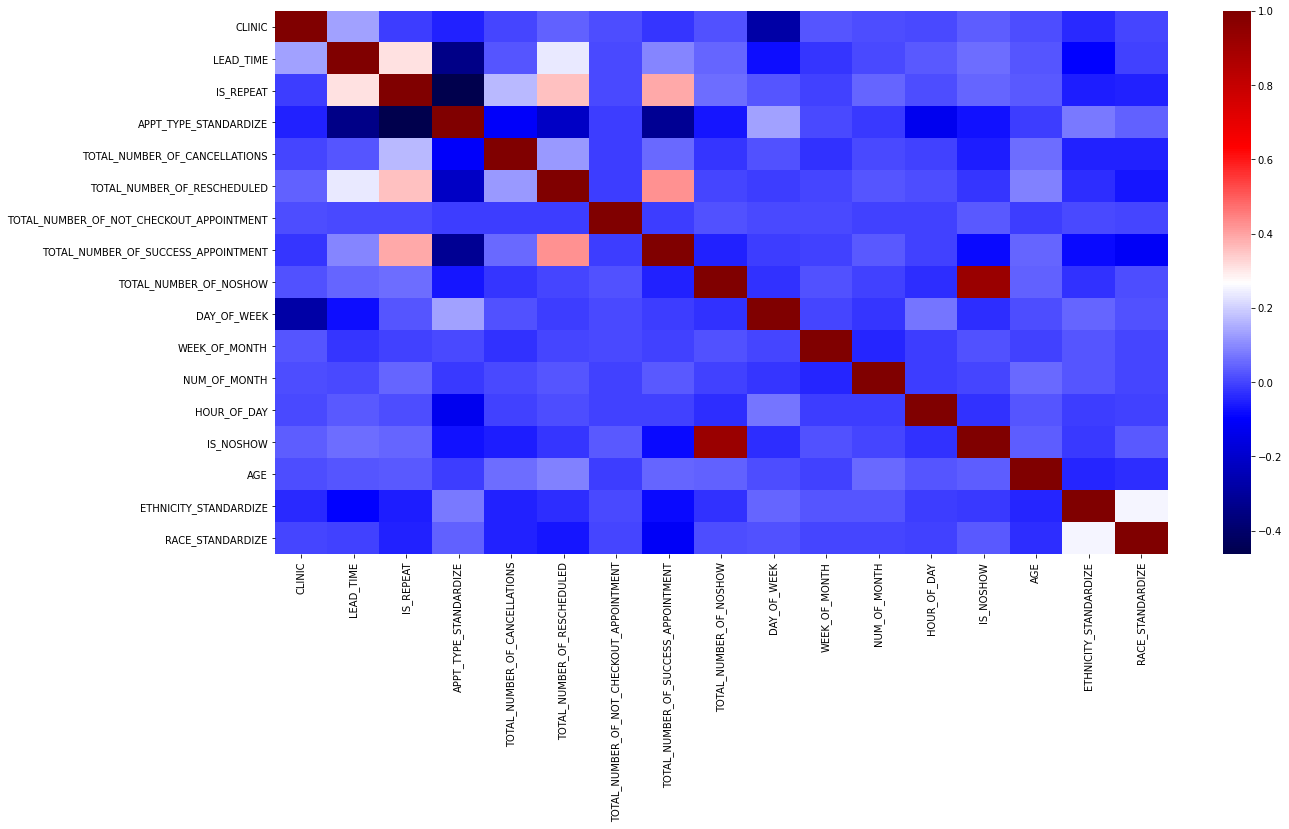

In [22]:
# Heatmap to find any high correlations
plt.figure(figsize=(20,10))
sns.heatmap(data=lbl_data.corr(), cmap="seismic")
plt.show()

# Label Data

In [23]:
X = lbl_data.drop('IS_NOSHOW', axis = 1) 
Y = lbl_data['IS_NOSHOW']

# Split Train and Test

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 100) 

# Model - RF 

In [25]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
ypred = rf.predict(X_test)
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))
print("Accuracy Score:", accuracy_score(y_test, ypred))
print("Recall Score:", recall_score(y_test, ypred))
print("Precision Score:", precision_score(y_test, ypred))
print("ROC AUC Score: ", roc_auc_score(y_test, ypred))
rf_fp, rf_tp, rf_threshold = roc_curve(y_test, ypred)
print("Threshold:", rf_threshold)

[[4282    0]
 [   0  293]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4282
           1       1.00      1.00      1.00       293

    accuracy                           1.00      4575
   macro avg       1.00      1.00      1.00      4575
weighted avg       1.00      1.00      1.00      4575

Accuracy Score: 1.0
Recall Score: 1.0
Precision Score: 1.0
ROC AUC Score:  1.0
Threshold: [inf  1.  0.]


# ROC Curve

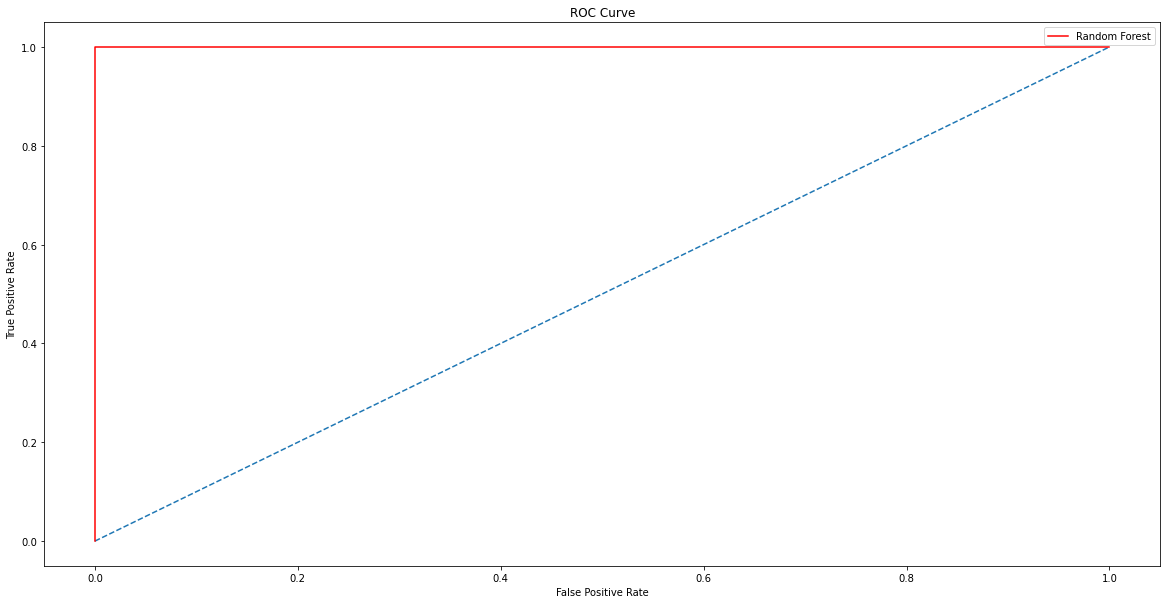

In [26]:
plt.figure(figsize=(20,10))
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(rf_fp, rf_tp, color="red", label = "Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

In [27]:
feature_importance_df = pd.DataFrame(X_train.columns, columns=["Feature"])
feature_importance_df["Importance"] = rf.feature_importances_
feature_importance_df.sort_values('Importance', ascending=False, inplace=True)
feature_importance_df = feature_importance_df.head(20)
feature_importance_df

,Feature,Importance
8,TOTAL_NUMBER_OF_NOSHOW,0.907458
4,TOTAL_NUMBER_OF_CANCELLATIONS,0.033269
7,TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT,0.015593
1,LEAD_TIME,0.012076
5,TOTAL_NUMBER_OF_RESCHEDULED,0.007987
11,NUM_OF_MONTH,0.004626
13,AGE,0.003654
3,APPT_TYPE_STANDARDIZE,0.002674
0,CLINIC,0.002605
12,HOUR_OF_DAY,0.002137


Text(0.5, 1.0, 'Plot Feature Importances')

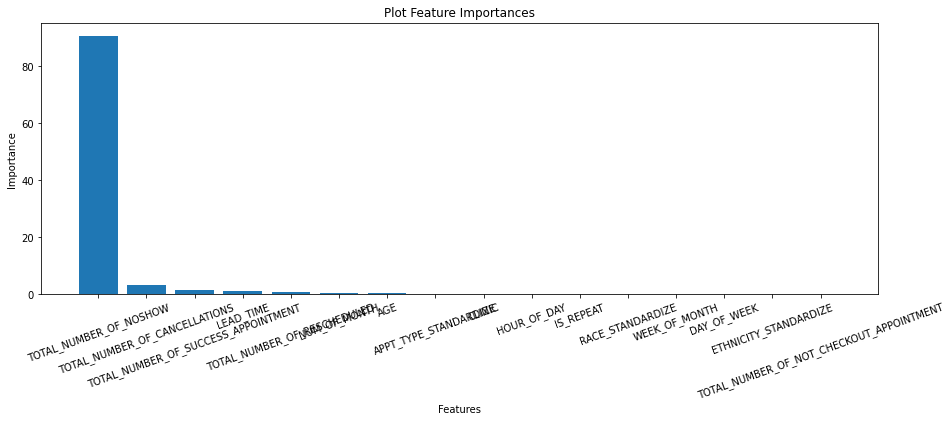

In [28]:
plt.figure(figsize=(15,5))
ax = feature_importance_df['Feature']
plt.bar(range(feature_importance_df.shape[0]), feature_importance_df['Importance']*100)
plt.xticks(range(feature_importance_df.shape[0]), feature_importance_df['Feature'], rotation = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Plot Feature Importances")

# Save Model

In [29]:
pickle_out = open("model_V2.pkl", "wb")
pickle.dump(rf, pickle_out)
pickle_out.close()

# Test Model

In [30]:
pkl_file = open('encoder_V2.pkl', 'rb')
encoder_dict_V2 = pickle.load(pkl_file) 
pkl_file.close()

print(encoder_dict)

{'CLINIC': ['ARCADIA CARE CENTER', 'BAKERSFIELD CARE CLINIC', 'ENCINO CARE CENTER', 'SANTA MONICA CLINIC', 'SOUTH BAY CARE CENTER', 'Unknown', 'VALENCIA CARE CENTER'], 'APPT_TYPE_STANDARDIZE': ['Follow-up', 'New', 'Others', 'Unknown'], 'ETHNICITY_STANDARDIZE': ['Hispanic', 'Non-Hispanic', 'Others', 'Unknown'], 'RACE_STANDARDIZE': ['African', 'Asian', 'European', 'MiddleEastern', 'NorthAmerican', 'Other', 'SouthAmerican', 'Unknown'], 'IS_NOSHOW': {'Y': 1, 'N': 0}, 'IS_REPEAT': {'Y': 1, 'N': 0}}


In [31]:
# example input

data = { 'CLINIC':'SANTA MONICA CLINIC', 
        'LEAD_TIME': 60, 
        'IS_REPEAT':'Y', 
        'APPT_TYPE_STANDARDIZE':'Follow-up',
       'TOTAL_NUMBER_OF_CANCELLATIONS':0, 
        'TOTAL_NUMBER_OF_RESCHEDULED':2,
       'TOTAL_NUMBER_OF_NOT_CHECKOUT_APPOINTMENT':0,
       'TOTAL_NUMBER_OF_SUCCESS_APPOINTMENT':4, 
        'TOTAL_NUMBER_OF_NOSHOW':1,
       'DAY_OF_WEEK':2, 
        'WEEK_OF_MONTH':3, 
        'NUM_OF_MONTH':1, 
        'HOUR_OF_DAY':10, 
        'AGE':16, 
        'ETHNICITY_STANDARDIZE':'Hispanic', 
        'RACE_STANDARDIZE':'European'
       }

# Convert the data into a DataFrame for easier manipulation
df = pd.DataFrame([data])

# Load the encoder dictionary from a pickle file
with open('encoder_V2.pkl', 'rb') as pkl_file:
    encoder_dict = pickle.load(pkl_file)

    
# Preprocess and encode the categorical columns
category_col = ['CLINIC', 'APPT_TYPE_STANDARDIZE', 'ETHNICITY_STANDARDIZE', 'RACE_STANDARDIZE']

for col in category_col:
    # Initialize a LabelEncoder
    le = preprocessing.LabelEncoder()
    
    # Convert the loaded classes list to a numpy array with dtype 'object'
    le.classes_ = np.array(encoder_dict[col], dtype=object)

    # Check and replace unknown values with 'Unknown'
    df[col] = df[col].apply(lambda x: x if x in le.classes_ else 'Unknown')
    
    # If 'Unknown' is not in le.classes_, add it or handle accordingly
    if 'Unknown' not in le.classes_:
        print(f"'Unknown' category not handled for {col}.")
        continue
    
    # Transform the data
    df[col] = le.transform(df[col])

# Add manual mapping here
manual_mappings = {'IS_REPEAT': {'Y': 1, 'N': 0}}

for col, mapping in manual_mappings.items():
    # Apply the mapping
    df[col] = df[col].map(mapping)

In [32]:
# Prediction Section

model = pickle.load(open('model_V2.pkl', 'rb'))
features_list = df.values.tolist()
prediction = model.predict(features_list)
print(prediction[0])

1


In [33]:
### LOCAL DEPLOYMENT and TESTING Section ###

In [ ]:
!streamlit run app_V3.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.93:8501

2024-03-15 21:07:20.261 Uncaught app exception
Traceback (most recent call last):
  File "/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/streamlit/elements/widgets/number_input.py", line 399, in _number_input
    JSNumber.validate_float_bounds(min_value, "`min_value`")
  File "/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/streamlit/js_number.py", line 98, in validate_float_bounds
    raise JSNumberBoundsException(
streamlit.js_number.JSNumberBoundsException: `min_value` (0) is not a float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/streamlit/runtime/scriptrunner/script_runner.py", line 535, in _run_script
    exec(code, module.__dict__)
  File "/Users/xiomara/Desktop/BSAN 6198/Project 2/app_V3.py", line 124, in

2024-03-15 21:13:16.579 Uncaught app exception
Traceback (most recent call last):
  File "/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/streamlit/elements/widgets/number_input.py", line 399, in _number_input
    JSNumber.validate_float_bounds(min_value, "`min_value`")
  File "/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/streamlit/js_number.py", line 98, in validate_float_bounds
    raise JSNumberBoundsException(
streamlit.js_number.JSNumberBoundsException: `min_value` (0) is not a float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/streamlit/runtime/scriptrunner/script_runner.py", line 535, in _run_script
    exec(code, module.__dict__)
  File "/Users/xiomara/Desktop/BSAN 6198/Project 2/app_V3.py", line 124, in <module>
    main()
  File "/Users/xiomara/Desktop/BSAN 6198/Project 2/app_V3.py", line 68, in main
    TOTAL_NUMBER_OF_NOT_CHECKOUT

2024-03-15 21:13:17.704 Uncaught app exception
Traceback (most recent call last):
  File "/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/streamlit/elements/widgets/number_input.py", line 399, in _number_input
    JSNumber.validate_float_bounds(min_value, "`min_value`")
  File "/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/streamlit/js_number.py", line 98, in validate_float_bounds
    raise JSNumberBoundsException(
streamlit.js_number.JSNumberBoundsException: `min_value` (0) is not a float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/xiomara/opt/anaconda3/lib/python3.8/site-packages/streamlit/runtime/scriptrunner/script_runner.py", line 535, in _run_script
    exec(code, module.__dict__)
  File "/Users/xiomara/Desktop/BSAN 6198/Project 2/app_V3.py", line 124, in <module>
    main()
  File "/Users/xiomara/Desktop/BSAN 6198/Project 2/app_V3.py", line 68, in main
    TOTAL_NUMBER_OF_NOT_CHECKOUT

In [ ]:
!pip install streamlit